<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/05_Transfer_Learning_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In Previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-Tuning

In [1]:
!nvidia-smi

Tue Feb 27 00:07:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Creating Helper functions

In previous notebooks, we've created a bunch of helper functions.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-27 00:07:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-02-27 00:07:57 (19.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Let's Get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application` and apply
them to our own problems (recognizing images of food)

In [4]:
# Get 10% of the training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-27 00:08:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   148MB/s    in 1.1s    

2024-02-27 00:08:07 (148 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirecteries are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.31994904e+02 2.42693878e+02 2.38566330e+02]
   [2.41892853e+02 2.52795914e+02 2.48464279e+02]
   [2.45500000e+02 2.54923477e+02 2.51846939e+02]
   ...
   [1.40081787e+02 1.08025543e+02 1.29300995e+02]
   [1.48571472e+02 1.15071495e+02 1.30642883e+02]
   [1.53800980e+02 1.27872475e+02 1.37612198e+02]]

  [[1.79658157e+02 1.90658157e+02 1.96372452e+02]
   [1.69943878e+02 1.80943878e+02 1.86658157e+02]
   [1.65520401e+02 1.74147949e+02 1.81051010e+02]
   ...
   [1.60969604e+02 1.23454170e+02 1.27938782e+02]
   [1.60642883e+02 1.19801048e+02 1.16295914e+02]
   [1.62504898e+02 1.24719254e+02 1.17882477e+02]]

  [[2.42158173e+02 2.52867355e+02 2.55000000e+02]
   [2.44602036e+02 2.54602036e+02 2.55000000e+02]
   [2.39489792e+02 2.48658173e+02 2.52755112e+02]
   ...
   [1.72801025e+02 1.27300842e+02 1.19469154e+02]
   [1.77454086e+02 1.24510193e+02 1.10596901e+02]
   [1.73591660e+02 1.21091660e+02 1.04734512e+02]]

  ...

  [[2.50785736e+02 2.55000000e+02 2.49785736e+02]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straigh forward, it runs our layers in sequential oreder


In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240227-000817
Epoch 1/5
24/24 [==============================] - 18s 261ms/step - loss: 1.8871 - accuracy: 0.4147 - val_loss: 1.3245 - val_accuracy: 0.7418
Epoch 2/5
24/24 [==============================] - 4s 170ms/step - loss: 1.1329 - accuracy: 0.7640 - val_loss: 0.8760 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 177ms/step - loss: 0.8239 - accuracy: 0.8173 - val_loss: 0.7344 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 4s 171ms/step - loss: 0.6807 - accuracy: 0.8453 - val_loss: 0.6318 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.5850 - accuracy: 0.8680 - val_loss: 0.5683 - val_accuracy: 0.8651


In [12]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 73ms/step - loss: 0.5645 - accuracy: 0.8632


[0.5645312070846558, 0.8632000088691711]

In [13]:
# check the layers in our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# Summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# Whole model summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

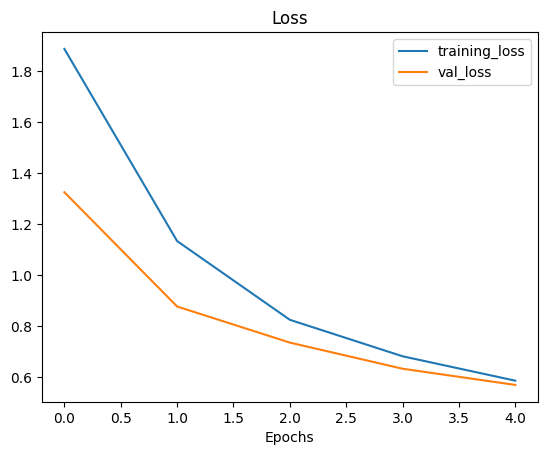

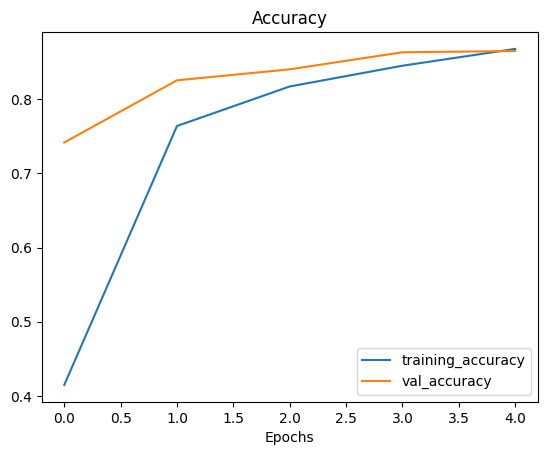

In [16]:
# Check out our models training curves
plot_loss_curves(history_10_percent)

##Getting a feature vector from a trained model

Let's Demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let;s use similar shaped tenspr of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [17]:
# Define Input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"SHape of Global Average Pooled 2D tensor :{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
SHape of Global Average Pooled 2D tensor :(1, 3)


In [18]:
 # Lets replicate the GlobalAveragePool2D Layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10 of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augumentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmenattion



## Getting and preprocessing data for model_1

In [19]:
# Downlaod and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2024-02-27 00:09:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   162MB/s    in 0.8s    

2024-02-27 00:09:18 (162 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images we're working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [22]:
# set up data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

benifits of using data augmentation inside the mmodel are:

* Perprocessing of images (augmenting them ) happens on the GPU (much faster) rather than CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations,zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255) # models like ResNet50V2 need Rescale but EfficientNet's have rescaling builtin
],name ="data_augmentation")

### Visualise our data augmentation layer

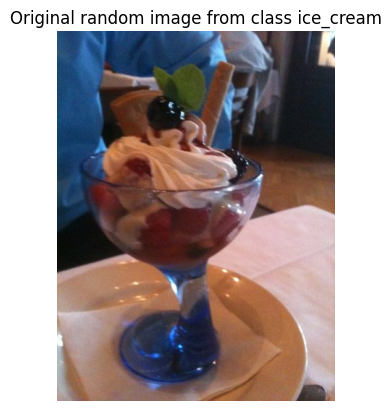

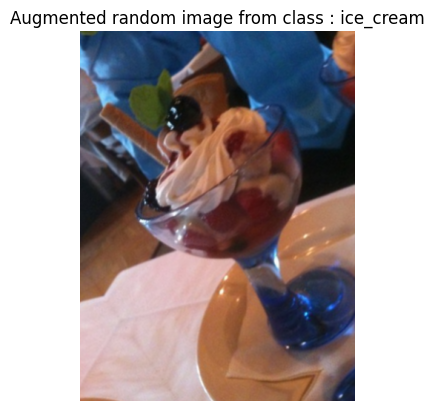

In [24]:
# Viwe a random image and compare it to augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mping.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now lets plot augmented image
augmented_img = data_augmentation(tf.expand_dims(img , axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class : {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup the base model and input shape , freezing the base model layers
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x,training=False)

# Pool output features of teh base
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make amodel using the inouts and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data/20240227-000924
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3734 - accuracy: 0.1429 - val_loss: 2.2217 - val_accuracy: 0.1513
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1141 - accuracy: 0.2857 - val_loss: 2.0922 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8883 - accuracy: 0.4143 - val_loss: 1.9818 - val_accuracy: 0.3586
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7422 - accuracy: 0.5714 - val_loss: 1.8644 - val_accuracy: 0.4178
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5810 - accuracy: 0.7143 - val_loss: 1.7756 - val_accuracy: 0.4737


In [26]:
# model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [27]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.7795 - accuracy: 0.4816


[1.779515027999878, 0.48159998655319214]

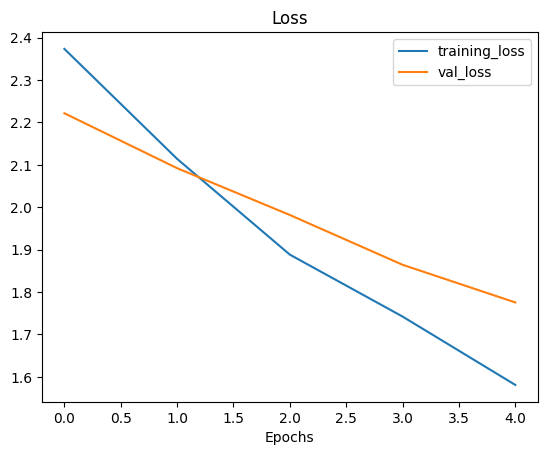

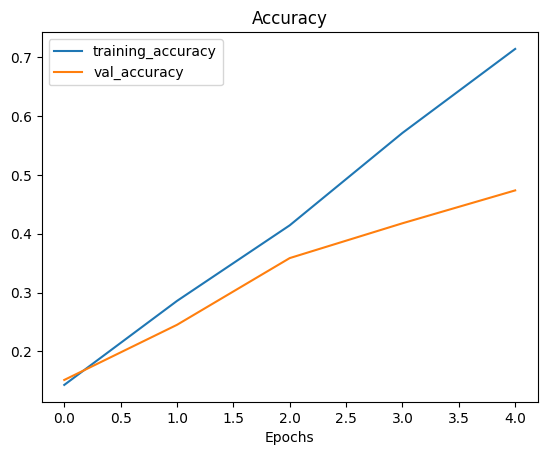

In [28]:
plot_loss_curves(history_1_percent)

## Model 2 with 10% of the training data and adding data augmentation as layer

In [29]:
# get 10% of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-27 00:10:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   132MB/s    in 1.2s    

2024-02-27 00:10:18 (132 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [30]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [31]:
# set up data loaders
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# create model 2 with data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255) # models like ResNet50V2 need Rescale but EfficientNet's have rescaling builtin
],name ="data_augmentation")

# setup input shape t our model

input_shape = (224,224,3)

# create a frozen base model (also called as the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainble = False

# Create the inputs and outputs (includeing the layers in between)
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentstion dosen't occur on test data)
x = base_model(x,training = False) # pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10,activation = "softmax" , name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


### Creating a model checkpoint callbacks

The ModelCheckpoint callback intermediatley saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [33]:
# Set checkpoint path
checkpoint_path = "10_precent_model_checkpoints_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callbacl = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [34]:
# Fit the model saving checkpoints

initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name ="transfer_learning",
                                                                 experiment_name = "10_percent_data_aug"),
                                     checkpoint_callbacl])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240227-001024
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.2985 - accuracy: 0.1840
Epoch 1: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 105s 3s/step - loss: 2.2985 - accuracy: 0.1840 - val_loss: 2.1999 - val_accuracy: 0.1793
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.0598 - accuracy: 0.2280
Epoch 2: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 55s 2s/step - loss: 2.0598 - accuracy: 0.2280 - val_loss: 1.7317 - val_accuracy: 0.3684
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.5600 - accuracy: 0.4493
Epoch 3: saving model to 10_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 45s 2s/step - loss: 1.5600 - accuracy: 0.4493 - val_loss: 1.2456 - val_accuracy: 0.5757
Epoch 4/5
24

In [35]:
results_10_per_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 1.7213 - accuracy: 0.5576


In [36]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 60ms/step - loss: 0.5645 - accuracy: 0.8632


[0.5645312666893005, 0.8632000088691711]

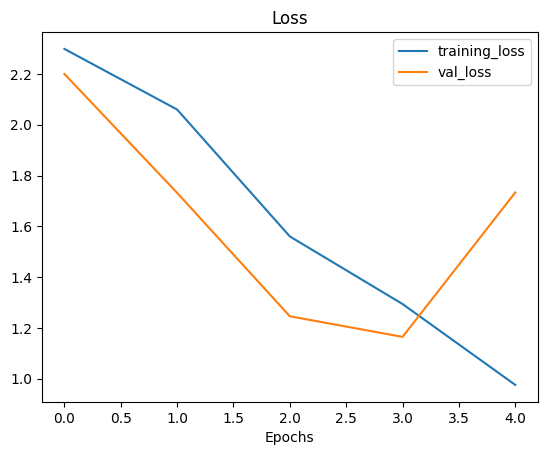

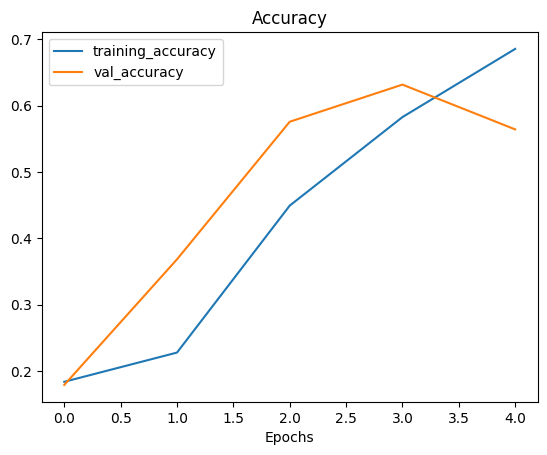

In [37]:
# plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpoints weights returns a model to a specefic checkpoint

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
# Evaluate model_2 with loaded weigths
loaded_weights_model_results = model_2.evaluate(test_data)


79/79 [==============================] - 6s 76ms/step - loss: 1.7213 - accuracy: 0.5576


In [40]:
# If the results from our previosuly evaluated model_2 match the loaded weights, everyrhing has worked!
results_10_per_data_aug == loaded_weights_model_results

False

In [41]:
results_10_per_data_aug

[1.7212615013122559, 0.5576000213623047]

In [42]:
loaded_weights_model_results

[1.7212618589401245, 0.5576000213623047]

In [43]:
# Check to see if loade model results are very close
import numpy as np
np.isclose(np.array(results_10_per_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

### Model_3 fine-tuning

* Fine-Tuning usualy works best after training a feature extraction model for a few epochs with large amounts of custom data

In [45]:
# Layers in our loaded model
model_2.layers

In [46]:
# Are these models trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79b9bcff2890> True
<keras.src.engine.sequential.Sequential object at 0x79b9b958a2f0> True
<keras.src.engine.functional.Functional object at 0x79b9b92b5660> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79b9b92e97b0> True
<keras.src.layers.core.dense.Dense object at 0x79b9b94459f0> True


In [49]:
#what layers are in our base_model (EfficientnetB0 and what layers are trainable)
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling_3 True
2 normalization_2 True
3 rescaling_4 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [50]:
# How many trainable variables are in our base_model
print(len(model_2.layers[2].trainable_variables))

211


In [54]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [51]:
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 True
1 rescaling_3 True
2 normalization_2 True
3 rescaling_4 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [55]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [56]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240227-004606
Epoch 5/10
24/24 [==============================] - 26s 716ms/step - loss: 0.7283 - accuracy: 0.7747 - val_loss: 0.8625 - val_accuracy: 0.7385
Epoch 6/10
24/24 [==============================] - 13s 545ms/step - loss: 0.5281 - accuracy: 0.8373 - val_loss: 0.8516 - val_accuracy: 0.7500
Epoch 7/10
24/24 [==============================] - 15s 621ms/step - loss: 0.4972 - accuracy: 0.8467 - val_loss: 0.8973 - val_accuracy: 0.7286
Epoch 8/10
24/24 [==============================] - 13s 517ms/step - loss: 0.4579 - accuracy: 0.8400 - val_loss: 0.8220 - val_accuracy: 0.7418
Epoch 9/10
24/24 [==============================] - 14s 544ms/step - loss: 0.4178 - accuracy: 0.8747 - val_loss: 0.8601 - val_accuracy: 0.7434
Epoch 10/10
24/24 [==============================] - 13s 528ms/step - loss: 0.4157 - accuracy: 0.8693 - val_loss: 0.9219 - val_accuracy: 0.7368


In [58]:
results_fine_tuned = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.8341 - accuracy: 0.7592


In [59]:
results_10_per_data_aug

[1.7212615013122559, 0.5576000213623047]

In [62]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()



5
11
[0.18400000035762787, 0.2280000001192093, 0.4493333399295807, 0.5826666951179504, 0.6853333115577698, 0.7746666669845581, 0.8373333215713501, 0.846666693687439, 0.8399999737739563, 0.874666690826416, 0.8693333268165588]


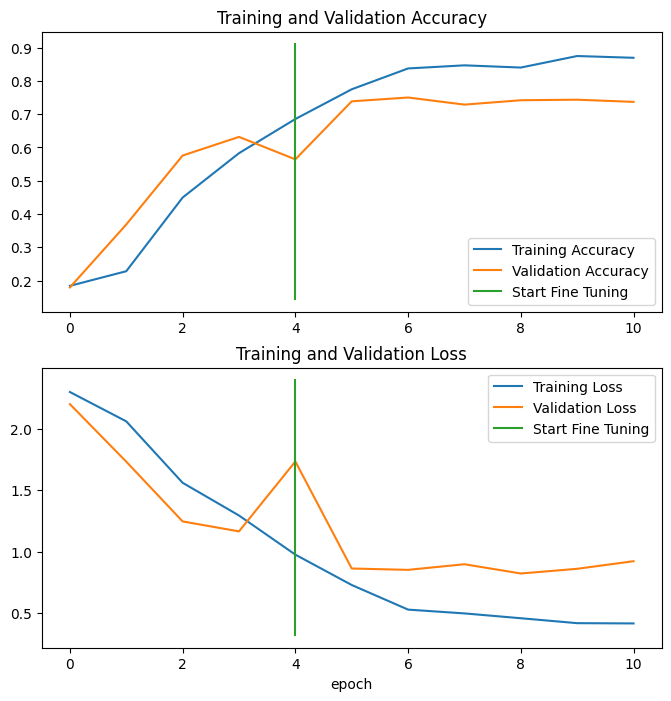

In [65]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.


In [66]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"



--2024-02-27 00:54:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  78.5MB/s    in 6.2s    

2024-02-27 00:54:36 (79.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [67]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [68]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The test dataset is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current model_2.


In [69]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.8341 - accuracy: 0.7592


[0.8340522646903992, 0.7591999769210815]

To keep our experiments clean, we'll load a create a new instance of model_2 using our create_base_model() function.

More specifically, we're trying to measure:

    Experiment 3 (previous one) - model_2 with 10 layers fine-tuned for 5 more epochs on 10% of the data.
    Experiment 4 (this one) - model_2 with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (model_2 feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of model_2.


In [75]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [78]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [81]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [82]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [83]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_6 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [84]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

In [85]:
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240227-011222
Epoch 5/10
235/235 [==============================] - 194s 774ms/step - loss: 0.7534 - accuracy: 0.7547 - val_loss: 0.2969 - val_accuracy: 0.9046
Epoch 6/10
235/235 [==============================] - 124s 525ms/step - loss: 0.4978 - accuracy: 0.8388 - val_loss: 0.2446 - val_accuracy: 0.9161
Epoch 7/10
235/235 [==============================] - 104s 442ms/step - loss: 0.4018 - accuracy: 0.8708 - val_loss: 0.2648 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 85s 358ms/step - loss: 0.3452 - accuracy: 0.8885 - val_loss: 0.2058 - val_accuracy: 0.9326
Epoch 9/10
235/235 [==============================] - 80s 335ms/step - loss: 0.3100 - accuracy: 0.8972 - val_loss: 0.2518 - val_accuracy: 0.9227
Epoch 10/10
235/235 [==============================] - 67s 285ms/step - loss: 0.2730 - accuracy: 0.9077 - val_loss: 0.2078 - val_accuracy: 0.9326


In [86]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 77ms/step - loss: 0.2308 - accuracy: 0.9236


[0.23081418871879578, 0.9236000180244446]

5
11
[0.18400000035762787, 0.2280000001192093, 0.4493333399295807, 0.5826666951179504, 0.6853333115577698, 0.7546666860580444, 0.8388000130653381, 0.8708000183105469, 0.888533353805542, 0.8971999883651733, 0.9077333211898804]


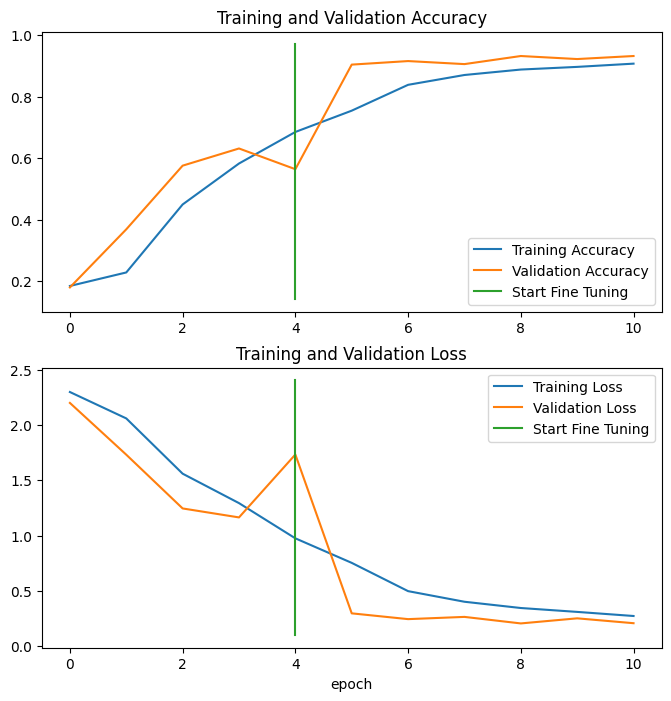

In [88]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_2,
                 new_history= history_fine_10_classes_full,
                 initial_epochs=5)